In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into a Tenors of 4-Dimensions 
transform = transforms.ToTensor()


In [3]:
# Train data
train_data = datasets.MNIST(root='cnn_data', train=True, download=True, transform=transform)

In [4]:
#Test data
test_data = datasets.MNIST(root='cnn_data', train=False, download=True, transform=transform)

In [5]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(train_data, batch_size=10, shuffle=False)

In [6]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 covolutional layers)
# This is just an example in the next video we'll build the model
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)


In [7]:
# Grab 1 MNIST record/image
for i,(X_Train, y_train) in enumerate(train_data):
    break

In [8]:
X_Train.shape

torch.Size([1, 28, 28])

In [9]:
x = X_Train.view(1,1,28,28)

In [10]:
# Perform our first convolution
x = F.relu(conv1(x)) # Reactified Linear Unit  for our activation function


In [11]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [12]:
# Pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernel of 2 and stride of 2


In [13]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [14]:
# Do our second convolutional layer
x = F.relu(conv2(x))


In [15]:
x.shape

torch.Size([1, 16, 11, 11])

In [16]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [17]:
x.shape # 11/2 = 5.5 but we have to round down, cause you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [18]:
(((28.2) / 2 - 2)) / 2

6.05

In [19]:
# Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # Fully conected layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
        # Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
        # Re-View to flatten it out
        X = X.view(-1,16*5*5) # negative one so that we can vary the batch size
        # Fully conected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [20]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# Loss Function Optimazer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# Smaller the learning rate, longer its gonna take

In [22]:
import time
start_time = time.time()
# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
test_correct = []
train_correct = []
# For loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    # Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1 # Start batches at 1
        y_pred = model(X_train) # get precited values from the trining, Not flatten 2D
        loss = criterion(y_pred, y_train) # how off are we?, Compare the prediction with correct answers y_train
        
        predicted = torch.max(y_pred.data,1)[1] # add up the number of correct predictions. Indexed off the first item
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. 
        trn_corr += batch_corr # keep track as we go along in training
        
        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print results
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad(): # No gradient, so we don't update our weights and biases with test data
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val =  model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
            tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    train_correct.append(trn_corr)

    
current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

/home/edgarrd11/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Batch: 600 Loss: 0.15999361872673035
Epoch: 0 Batch: 1200 Loss: 0.18979428708553314
Epoch: 0 Batch: 1800 Loss: 0.5580862164497375
Epoch: 0 Batch: 2400 Loss: 0.2070169746875763
Epoch: 0 Batch: 3000 Loss: 0.006888723466545343
Epoch: 0 Batch: 3600 Loss: 0.3311269283294678
Epoch: 0 Batch: 4200 Loss: 0.004664993844926357
Epoch: 0 Batch: 4800 Loss: 0.002031726064160466
Epoch: 0 Batch: 5400 Loss: 0.06567355245351791
Epoch: 0 Batch: 6000 Loss: 0.0007259048288688064
Epoch: 1 Batch: 600 Loss: 0.004907811991870403
Epoch: 1 Batch: 1200 Loss: 0.3916364014148712
Epoch: 1 Batch: 1800 Loss: 0.002924952656030655
Epoch: 1 Batch: 2400 Loss: 0.003605760633945465
Epoch: 1 Batch: 3000 Loss: 0.03269127756357193
Epoch: 1 Batch: 3600 Loss: 0.27343201637268066
Epoch: 1 Batch: 4200 Loss: 0.03158869594335556
Epoch: 1 Batch: 4800 Loss: 0.0011037382064387202
Epoch: 1 Batch: 5400 Loss: 0.00024213967844843864
Epoch: 1 Batch: 6000 Loss: 0.1644541323184967
Epoch: 2 Batch: 600 Loss: 0.07188046723604202
Epoch: 2

In [26]:
train_losses

[0.0007259048288688064,
 0.1644541323184967,
 0.21246211230754852,
 0.007428494282066822,
 0.00030600989703089]

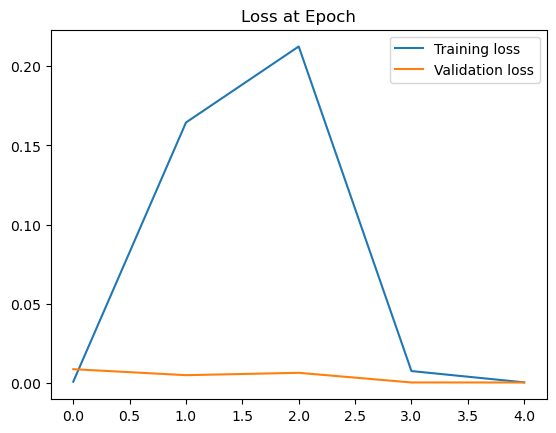

In [24]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses] # Convert tensor into a python list
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at Epoch")
plt.legend()

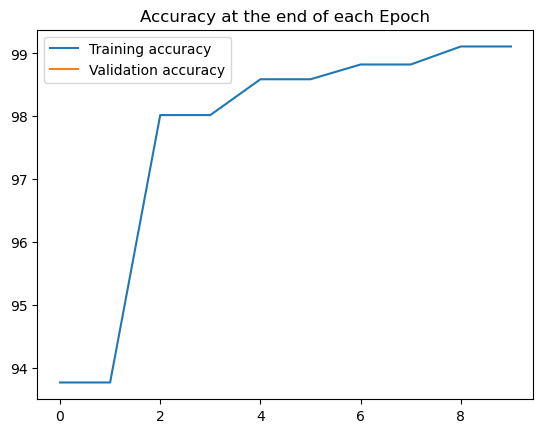

In [28]:
# Graph the accuracy 
plt.plot([t/600 for t in train_correct],label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [30]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
# Did for correct
correct.item()/len(test_data)*100

98.44000000000001

In [32]:
# Grab an image
test_data[4143] # Tensor with an image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
# Grab just the data
test_data[4143][0]


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [34]:
# Reshape it
test_data[4143][0].reshape(28,28)


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

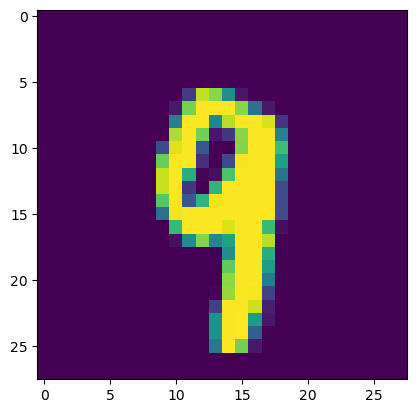

In [35]:
# Show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [36]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28))# Batch the size of 1,1 color channel, 28x28 image

In [38]:
new_prediction.argmax()

tensor(9)